# 7강 정형데이터 분류 베이스라인 모델 3 추가 피처 엔지니어링

- 세번째 베이스라인 모델에서 7강에서 설명한 피처 엔지니어링 추가 구현
- 3,6,9,12
- cnt_month, mean_total
- diff
- 15,18,21 (24개월은 importance 너무 낮아 제거)
- product_importance (환불포함)
- last order, last total 추가
- cumsum 추가
- 통계값 전부 다시 추가
- prd_importance 제거

## Function 정의

- seed_everything() : seed 고정 함수
- generate_label() : label 생성 함수
- print_score() : 평가지표 출력 함수
- feature_preprocessing() : 데이터 전처리 함수(label encoding, 결측치 처리)
- feature_engineering2() : 피처 엔지니어링 함수
- make_lgb_oof_prediction() : LightGBM cross validation out of fold train/predict 함수
- plot_feature_importances() : LightGBM 피처 중요도 플롯 함수

## Library Import

In [1]:
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

import os, sys, gc, warnings, random

from datetime import date
import datetime
import dateutil.relativedelta

# Data manipulation
import pandas as pd 
import numpy as np
import re

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GroupKFold
from sklearn.ensemble import RandomForestClassifier

import lightgbm as lgb

from tqdm.notebook import trange, tqdm

from IPython.display import display

%matplotlib inline

pd.options.display.max_rows = 10000
pd.options.display.max_columns = 1000
pd.options.display.max_colwidth = 1000

## Fix Seed 함수 정의

In [2]:
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
SEED = 42
seed_everything(SEED)

## 레이블 생성 함수 정의

- 레이블 생성 함수는 연월을 인자로 받아서 고객 아이디별로 총 구매액이 인자로 받는 구매액 임계값을 넘는지 여부를 바이너리 레이블로 생성하는 함수

In [3]:
TOTAL_THRES = 300

'''
    입력인자로 받는 year_month에 대해 고객 ID별로 총 구매액이
    구매액 임계값을 넘는지 여부의 binary label을 생성하는 함수
'''
def generate_label(df, year_month, total_thres=TOTAL_THRES, print_log=False):
    df = df.copy()
    
    # year_month에 해당하는 label 데이터 생성
    df['year_month'] = df['order_date'].dt.strftime('%Y-%m')
    df.reset_index(drop=True, inplace=True)

    # year_month 이전 월의 고객 ID 추출
    cust = df[df['year_month']<year_month]['customer_id'].unique()
    # year_month에 해당하는 데이터 선택
    df = df[df['year_month']==year_month]
    
    # label 데이터프레임 생성
    label = pd.DataFrame({'customer_id':cust})
    label['year_month'] = year_month
    
    # year_month에 해당하는 고객 ID의 구매액의 합 계산
    grped = df.groupby(['customer_id','year_month'], as_index=False)[['total']].sum()
    
    # label 데이터프레임과 merge하고 구매액 임계값을 넘었는지 여부로 label 생성
    label = label.merge(grped, on=['customer_id','year_month'], how='left')
    label['total'].fillna(0.0, inplace=True)
    label['label'] = (label['total'] > total_thres).astype(int)

    # 고객 ID로 정렬
    label = label.sort_values('customer_id').reset_index(drop=True)
    if print_log: print(f'{year_month} - final label shape: {label.shape}')
    
    return label

## 평가지표 출력 함수 정의

In [4]:
def print_score(label, pred, prob_thres=0.5):
    print('Precision: {:.5f}'.format(precision_score(label, pred>prob_thres)))
    print('Recall: {:.5f}'.format(recall_score(label, pred>prob_thres)))
    print('F1 Score: {:.5f}'.format(f1_score(label, pred>prob_thres)))
    print('ROC AUC Score: {:.5f}'.format(roc_auc_score(label, pred)))

## 데이터 전처리 함수 정의
- 범주형 변수 레이블 인코딩
- 결측치 중위값으로 채움

In [5]:
def feature_preprocessing(train, test, features, do_imputing=True):
    x_tr = train.copy()
    x_te = test.copy()
    
    # 범주형 피처 이름을 저장할 변수
    cate_cols = []

    # 레이블 인코딩
    for f in features:
        if x_tr[f].dtype.name == 'object': # 데이터 타입이 object(str)이면 레이블 인코딩
            cate_cols.append(f)
            le = LabelEncoder()
            # train + test 데이터를 합쳐서 레이블 인코딩 함수에 fit
            le.fit(list(x_tr[f].values) + list(x_te[f].values))
            
            # train 데이터 레이블 인코딩 변환 수행
            x_tr[f] = le.transform(list(x_tr[f].values))
            
            # test 데이터 레이블 인코딩 변환 수행
            x_te[f] = le.transform(list(x_te[f].values))

    print('categorical feature:', cate_cols)

    if do_imputing:
        # 중위값으로 결측치 채우기
        imputer = SimpleImputer(strategy='median')

        x_tr[features] = imputer.fit_transform(x_tr[features])
        x_te[features] = imputer.transform(x_te[features])
    
    return x_tr, x_te

In [6]:
def month_mean(df, year_month):
    df = df.copy()
    
    data = df[df['order_date']<year_month]
    
    # 고백별 월별 total sum
    cum_month = data.groupby(['customer_id','order_month'])['total'].sum().reset_index(name='sum_total')

    # 고객별 주문 한 month count
    cnt_month = cum_month.groupby(['customer_id'])['order_month'].count().reset_index(name='cnt_month')

    # 고객별, 전체 구매 total(sum)
    cum_month_sum = cum_month.groupby('customer_id')['sum_total'].sum().reset_index(name='sum_total')
    # 고객별, 구매 월 수(count)
    cum_month_sum = pd.merge(cum_month_sum,cnt_month,on='customer_id',how='left')
    # 고객별, 월 평균 구매금액
    cum_month_sum['mean_total'] = cum_month_sum['sum_total'] / cum_month_sum['cnt_month']
    
    cum_month_agg = cum_month_sum.loc[:,['customer_id','cnt_month','mean_total']]
    
    return cum_month_agg

In [7]:
def prod_importance(df,year_month) :
    df = df.copy()
    
    data = df[df['order_month']<year_month]
    
    data['product_id_clean'] = ["".join(re.findall("[0-9]+", code)) for code in data.product_id]
    data['product_id_clean'] = data.product_id_clean.replace(r'^\s*$', np.nan, regex=True)
    
    product = data.loc[:,['product_id_clean','quantity','price']]
#     product = product[product['quantity'] > 0]
    
    product_data = product.groupby(['product_id_clean'])['quantity'].mean().reset_index(name='prod_qnt_mean')
    prod_price = product.groupby('product_id_clean')['price'].max().reset_index(name='prod_price_max')

    product_data = pd.merge(product_data,prod_price,on='product_id_clean', how='left')
    
    product_data['prod_importance'] = product_data['prod_qnt_mean'] * product_data['prod_price_max']
#     product_data = product_data.sort_values(by=['prod_importange'],axis=0, ascending=True)
#     product_data = product_data.reset_index(drop=True)
#     product_data['prod_index'] = product_data.index
    
    data = pd.merge(data, product_data, on='product_id_clean', how='left')
    
    return data

In [8]:
# 고객별 중요한 상품 매칭
def cum_prd_feature(df, year_month) :
    data = prod_importance(df, year_month)
    
#     dd = data.groupby(['customer_id','prod_index'])['order_date'].count().reset_index(name='prd_cnt')
    dd = data.groupby(['customer_id','prod_importance'])['order_date'].count().reset_index(name='prd_cnt')
    cc = dd.loc[dd.groupby(['customer_id'])['prd_cnt'].idxmax()]
    cc['prd_imp_total'] = cc['prod_importance']*cc['prd_cnt']
    return cc

In [9]:
# 고객별 마지막 주문월과 해당 월 total
def last_bought(df,year_month):
    a = df[df['order_month']<year_month].groupby(['customer_id','order_month'],as_index=False).sum()
    a = a.drop_duplicates('customer_id', keep='last')
    a=a.reset_index()
    a['last_month'] = a['order_month']
    a['last_total'] = a['total']
    return a.loc[:,['customer_id','last_month','last_total']]

In [10]:
# bb = last_bought(data,'2011-12')
# bb.describe()

### 예측 달과 차이

In [11]:
def month_delta(cum_month_cnt):  #start_date, end_date
    if cum_month_cnt['month_cnt'] > 1 :
        if cum_month_cnt['month_lead']!='nan' :
            end_date = datetime.datetime.strptime(cum_month_cnt['order_month_str'], "%Y-%m")
            start_date = datetime.datetime.strptime(cum_month_cnt['month_lead'], "%Y-%m")
            delta = dateutil.relativedelta.relativedelta(end_date, start_date)
        else : return 0
    else :
        return 0
    # >>> relativedelta(years=+2, months=+3, days=+28)
    return 12 * delta.years + delta.months

In [12]:
def month_func(cc):
    if cc['month_cnt-1'] == 0 :
        return 0
    else :
        return int(round(cc['diff_sum']/cc['month_cnt-1'],0))

In [13]:
def month_add(cc) :
    last = datetime.datetime.strptime(cc['last_month'], "%Y-%m")
    if cc['diff_mean'] != 0 :
        month_add = last + dateutil.relativedelta.relativedelta(months = cc['diff_mean'])
    elif cc['diff_mean'] == 0 :
        month_add = last + dateutil.relativedelta.relativedelta(months = cc['all_mean'])
    return month_add

In [14]:
def month_delta2(cc):  #start_date, end_date
    end_date = datetime.datetime.strptime(cc['year_month'], "%Y-%m")
    start_date = datetime.datetime.strptime(cc['month_add_mean'], "%Y-%m")
    delta = dateutil.relativedelta.relativedelta(end_date, start_date)
    # >>> relativedelta(years=+2, months=+3, days=+28)
    return 12 * delta.years + delta.months

In [15]:
def diff_func_fin(df, year_month):
    df = df.copy()
    data = df[df['order_date']<year_month]
    
#     data["order_day"] = data['order_date'].astype(str)
#     data['order_month'] = data['order_day'].str.slice(start=0,stop=7)
    data['order_month_str'] = data['order_month'].astype('str')
    cum_month = data.groupby(['customer_id','order_month_str'])['order_month_str'].count().reset_index(name='month_count')
    cum_month['month_lead'] = cum_month.groupby('customer_id')['order_month_str'].shift(1)
    month_cum_cnt = cum_month.groupby(['customer_id'])['order_month_str'].count().reset_index(name='month_cnt')
    cum_month_cnt = cum_month.merge(month_cum_cnt, on='customer_id',how='left')
    cum_month_cnt['month_lead'] = cum_month_cnt['month_lead'].astype('str')
    cum_month_cnt['month_lead'] = cum_month_cnt['month_lead'].fillna(pd.Timedelta('0'))
    cum_month_cnt['month_diff'] = cum_month_cnt.apply(month_delta,axis=1)
    
    cum_month_cnt['month_cnt-1'] = cum_month_cnt['month_cnt']-1
    cc = cum_month_cnt.groupby(['customer_id','month_cnt-1'])['month_diff'].sum().reset_index(name='diff_sum')
    
    # last_month 추가
    dd = cum_month_cnt.groupby(['customer_id'])['order_month_str'].max().reset_index(name='last_month')
    cc = cc.merge(dd, on='customer_id', how='left')
    
    # 평균 구매주기
    cc['diff_mean'] = cc.apply(month_func,axis=1)
    
    mm = cc[cc['diff_mean']!=0]['diff_mean'].mean()
    mm = int(round(mm,0))
    cc['all_mean'] = mm
    
    # last month + 평균 구매주기
    cc['month_add_mean'] = cc.apply(month_add,axis=1)
    
    cc["order_day"] = cc['month_add_mean'].astype('str')
    cc['month_add_mean'] = cc['order_day'].str.slice(start=0,stop=7)
    cc['year_month'] = year_month
    cc['diff_fin'] = cc.apply(month_delta2,axis=1)
    
    final = cc.loc[:,['customer_id','diff_fin']]
    return final

## 피처 엔지니어링 함수 정의
- Pandas groupby aggregation 함수를 사용한 피처 엔지니어링

In [16]:
def feature_engineering2(df, year_month):
    
    df = df.copy()
    
    # year_month 이전 월 계산
    d = datetime.datetime.strptime(year_month, "%Y-%m")
    prev_ym = d - dateutil.relativedelta.relativedelta(months=1)
    prev_ym = prev_ym.strftime('%Y-%m')
    
    # mean_total 
    train_mean = month_mean(df,prev_ym)
    test_mean = month_mean(df,year_month)
    
    
#     # prd_importance
#     train_prd = cum_prd_feature(df,prev_ym)
#     test_prd = cum_prd_feature(df,year_month)
    
#     # last_order
#     train_last = last_bought(df,prev_ym)
#     test_last = last_bought(df,year_month)
    
    # diff_month
    train_diff = diff_func_fin(df,prev_ym)
    test_diff = diff_func_fin(df,year_month)
    

     # customer_id 기준으로 pandas group by 후 total, quantity, price 누적합 계산
    df['cumsum_total_by_cust_id'] = df.groupby(['customer_id'])['total'].cumsum()
    df['cumsum_quantity_by_cust_id'] = df.groupby(['customer_id'])['quantity'].cumsum()
    df['cumsum_price_by_cust_id'] = df.groupby(['customer_id'])['price'].cumsum()

    # product_id 기준으로 pandas group by 후 total, quantity, price 누적합 계산
    df['cumsum_total_by_prod_id'] = df.groupby(['product_id'])['total'].cumsum()
    df['cumsum_quantity_by_prod_id'] = df.groupby(['product_id'])['quantity'].cumsum()
    df['cumsum_price_by_prod_id'] = df.groupby(['product_id'])['price'].cumsum()
    
    # order_id 기준으로 pandas group by 후 total, quantity, price 누적합 계산
    df['cumsum_total_by_order_id'] = df.groupby(['order_id'])['total'].cumsum()
    df['cumsum_quantity_by_order_id'] = df.groupby(['order_id'])['quantity'].cumsum()
    df['cumsum_price_by_order_id'] = df.groupby(['order_id'])['price'].cumsum()  
    
    df['order_ts'] = df['order_date'].astype(np.int64)//1e9
    df['order_ts_diff'] = df.groupby(['customer_id'])['order_ts'].diff()
    df['quantity_diff'] = df.groupby(['customer_id'])['quantity'].diff()
    df['price_diff'] = df.groupby(['customer_id'])['price'].diff()
    df['total_diff'] = df.groupby(['customer_id'])['total'].diff()
    
    df['order_ts'] = df['order_date'].astype(np.int64)//1e9
    df['order_ts_diff'] = df.groupby(['customer_id'])['order_ts'].diff()
    df['quantity_diff'] = df.groupby(['customer_id'])['quantity'].diff()
    df['price_diff'] = df.groupby(['customer_id'])['price'].diff()
    df['total_diff'] = df.groupby(['customer_id'])['total'].diff()
    
    # train, test 데이터 선택
    train = df[df['order_date'] < prev_ym]
    test = df[df['order_date'] < year_month]
    
    # train, test 레이블 데이터 생성
    train_label = generate_label(df, prev_ym)[['customer_id','year_month','label']]
    test_label = generate_label(df, year_month)[['customer_id','year_month','label']]
    
        
    ### 3개월 데이터 정보 feature 추가 ############################
    # train(7,8,9로 10월을)
    # 직전 3개월
    three_prev_ym = d - dateutil.relativedelta.relativedelta(months=4)
    three_total = train[train.order_date >= three_prev_ym].groupby('customer_id').total.sum()
    three_total = three_total.rename('total_3').reset_index()
    train_label = train_label.merge(three_total, on=['customer_id'], how='left')
    
    # 직전 6개월
    six_prev_ym = d - dateutil.relativedelta.relativedelta(months=7)
    six_total = train[train.order_date >= six_prev_ym].groupby('customer_id').total.sum()
    six_total = six_total.rename('total_6').reset_index()
    train_label = train_label.merge(six_total, on=['customer_id'], how='left')
    
    # 직전 9개월
    nine_prev_ym = d - dateutil.relativedelta.relativedelta(months=10)
    nine_total = train[train.order_date >= nine_prev_ym].groupby('customer_id').total.sum()
    nine_total = nine_total.rename('total_9').reset_index()
    train_label = train_label.merge(nine_total, on=['customer_id'], how='left')
    
    # 직전 12개월
    twelve_prev_ym = d - dateutil.relativedelta.relativedelta(months=13)
    twelve_total = train[train.order_date >= twelve_prev_ym].groupby('customer_id').total.sum()
    twelve_total = twelve_total.rename('total_12').reset_index()
    train_label = train_label.merge(twelve_total, on=['customer_id'], how='left')
    
    # 직전 15개월
    fifteen_prev_ym = d - dateutil.relativedelta.relativedelta(months=16)
    fifteen_total = train[train.order_date >= fifteen_prev_ym].groupby('customer_id').total.sum()
    fifteen_total = fifteen_total.rename('total_15').reset_index()  # 컬럼명 설정
    train_label = train_label.merge(fifteen_total, on=['customer_id'], how='left')  # test dataset에 feature 추가
    
    # 직전 18개월
    eighteen_prev_ym = d - dateutil.relativedelta.relativedelta(months=19)
    eighteen_total = train[train.order_date >= eighteen_prev_ym].groupby('customer_id').total.sum()
    eighteen_total = eighteen_total.rename('total_18').reset_index()
    train_label = train_label.merge(eighteen_total, on=['customer_id'], how='left')
    
    # 직전 21개월
    twenty_prev_ym = d - dateutil.relativedelta.relativedelta(months=22)
    twenty_total = train[train.order_date >= twenty_prev_ym].groupby('customer_id').total.sum()
    twenty_total = twenty_total.rename('total_21').reset_index()
    train_label = train_label.merge(twenty_total, on=['customer_id'], how='left')
    
#     # 직전 24개월
#     twenty4_prev_ym = d - dateutil.relativedelta.relativedelta(months=25)
#     twenty4_total = train[train.order_date >= twenty4_prev_ym].groupby('customer_id').total.sum()
#     twenty4_total = twenty4_total.rename('total_24').reset_index()
#     all_train_data = all_train_data.merge(twenty4_total, on=['customer_id'], how='left')
    
    # mean_total : month_mean()
    train_label = train_label.merge(train_mean, on=['customer_id'], how = 'left')
    # prd_importance()
#     train_label = train_label.merge(train_prd, on=['customer_id'], how = 'left')
    # last_bought()
#     train_label = train_label.merge(train_last, on=['customer_id'], how = 'left')
    # diff_month
    train_label = train_label.merge(train_diff, on=['customer_id'], how = 'left')
    ### 추가 end  ################################################
    
    # group by aggregation 함수 선언
    agg_func = ['mean','max','min','sum','count','std','skew']
    agg_dict = {
        'quantity': agg_func,
        'price': agg_func,
        'total': agg_func,
        'cumsum_total_by_cust_id': agg_func,
        'cumsum_quantity_by_cust_id': agg_func,
        'cumsum_price_by_cust_id': agg_func,
        'cumsum_total_by_prod_id': agg_func,
        'cumsum_quantity_by_prod_id': agg_func,
        'cumsum_price_by_prod_id': agg_func,
        'cumsum_total_by_order_id': agg_func,
        'cumsum_quantity_by_order_id': agg_func,
        'cumsum_price_by_order_id': agg_func,
        'order_id': ['nunique'],
        'product_id': ['nunique'],
        'order_ts': ['first','last'],
        'order_ts_diff': agg_func,
        'quantity_diff': agg_func,
        'price_diff': agg_func,
        'total_diff': agg_func,
    }
    all_train_data = pd.DataFrame()
    
    for i, tr_ym in enumerate(train_label['year_month'].unique()):
        # group by aggretation 함수로 train 데이터 피처 생성
        train_agg = train.loc[train['order_date'] < tr_ym].groupby(['customer_id']).agg(agg_dict)

        new_cols = []
        for col in agg_dict.keys():
            for stat in agg_dict[col]:
                if type(stat) is str:
                    new_cols.append(f'{col}-{stat}')
                else:
                    new_cols.append(f'{col}-mode')

        train_agg.columns = new_cols
        train_agg.reset_index(inplace = True)
        
        train_agg['year_month'] = tr_ym
        
        all_train_data = all_train_data.append(train_agg)
    
    all_train_data = train_label.merge(all_train_data, on=['customer_id', 'year_month'], how='left')

    features = all_train_data.drop(columns=['customer_id', 'label', 'year_month'#,'order_ts_diff-min'#'last_month',
#                                             'total-count'
# ,'cumsum_total_by_cust_id-count','cumsum_quantity_by_cust_id-count',
# 'cumsum_price_by_cust_id-count','cumsum_total_by_prod_id-count','cumsum_quantity_by_prod_id-count',
# 'cumsum_price_by_prod_id-count','cumsum_total_by_order_id-count','cumsum_quantity_by_order_id-count',
# 'cumsum_price_by_order_id-count'
#                                             ,'order_ts_diff-count','quantity_diff-count',
# 'price_diff-count','total_diff-count'
                                           ]).columns
    
    
    ########## Test dataset ##########

    ### 3개월 데이터 정보 feature 추가 ########################
    # validation(8,9,10로 11월을)
    three_prev_ym = d - dateutil.relativedelta.relativedelta(months=3)
    three_total = test[test.order_date >= three_prev_ym].groupby('customer_id').total.sum()
    three_total = three_total.rename('total_3').reset_index()  # 컬럼명 설정
    test_label = test_label.merge(three_total, on=['customer_id'], how='left')  # test dataset에 feature 추가
    
    # 직전 6개월
    six_prev_ym = d - dateutil.relativedelta.relativedelta(months=6)
    six_total = test[test.order_date >= six_prev_ym].groupby('customer_id').total.sum()
    six_total = six_total.rename('total_6').reset_index()
    test_label = test_label.merge(six_total, on=['customer_id'], how='left')
    
    # 직전 9개월
    nine_prev_ym = d - dateutil.relativedelta.relativedelta(months=9)
    nine_total = test[test.order_date >= nine_prev_ym].groupby('customer_id').total.sum()
    nine_total = nine_total.rename('total_9').reset_index()
    test_label = test_label.merge(nine_total, on=['customer_id'], how='left')
    
    # 직전 12개월
    twelve_prev_ym = d - dateutil.relativedelta.relativedelta(months=12)
    twelve_total = test[test.order_date >= twelve_prev_ym].groupby('customer_id').total.sum()
    twelve_total = twelve_total.rename('total_12').reset_index()
    test_label = test_label.merge(twelve_total, on=['customer_id'], how='left')
    
    # 직전 15개월
    fifteen_prev_ym = d - dateutil.relativedelta.relativedelta(months=15)
    fifteen_total = test[test.order_date >= fifteen_prev_ym].groupby('customer_id').total.sum()
    fifteen_total = fifteen_total.rename('total_15').reset_index()  # 컬럼명 설정
    test_label = test_label.merge(fifteen_total, on=['customer_id'], how='left')  # test dataset에 feature 추가
    
    # 직전 18개월
    eighteen_prev_ym = d - dateutil.relativedelta.relativedelta(months=18)
    eighteen_total = test[test.order_date >= eighteen_prev_ym].groupby('customer_id').total.sum()
    eighteen_total = eighteen_total.rename('total_18').reset_index()
    test_label = test_label.merge(eighteen_total, on=['customer_id'], how='left')
    
    # 직전 21개월
    twenty_prev_ym = d - dateutil.relativedelta.relativedelta(months=21)
    twenty_total = test[test.order_date >= twenty_prev_ym].groupby('customer_id').total.sum()
    twenty_total = twenty_total.rename('total_21').reset_index()
    test_label = test_label.merge(twenty_total, on=['customer_id'], how='left')
    
#     # 직전 24개월
#     twenty4_prev_ym = d - dateutil.relativedelta.relativedelta(months=24)
#     twenty4_total = test[test.order_date >= twenty4_prev_ym].groupby('customer_id').total.sum()
#     twenty4_total = twenty4_total.rename('total_24').reset_index()
#     test_data = test_data.merge(twenty4_total, on=['customer_id'], how='left')
    
    # mean_total : month_mean()
    test_label = test_label.merge(test_mean, on=['customer_id'], how = 'left')
    # prd_importance()
#     test_label = test_label.merge(train_prd, on=['customer_id'], how = 'left')
    # last_bought()
#     test_label = test_label.merge(test_last, on=['customer_id'], how = 'left')
    # diff_month
    test_label = test_label.merge(test_diff, on=['customer_id'], how = 'left')
    ### 추가 end #############################################
    
    # group by aggretation 함수로 test 데이터 피처 생성
    test_agg = test.groupby(['customer_id']).agg(agg_dict)
    test_agg.columns = new_cols
    
    test_data = test_label.merge(test_agg, on=['customer_id'], how='left')
    
    # train, test 데이터 전처리
    x_tr, x_te = feature_preprocessing(all_train_data, test_data, features)
    
    print('x_tr.shape', x_tr.shape, ', x_te.shape', x_te.shape)
    
    return x_tr, x_te, all_train_data['label'], features

## LightGBM cross validation out of fold train/predict 함수 정의

In [17]:
def make_lgb_oof_prediction(train, y, test, features, categorical_features='auto', model_params=None, folds=10):
    x_train = train[features]
    x_test = test[features]
    
    # 테스트 데이터 예측값을 저장할 변수
    test_preds = np.zeros(x_test.shape[0])
    
    # Out Of Fold Validation 예측 데이터를 저장할 변수
    y_oof = np.zeros(x_train.shape[0])
    
    # 폴드별 평균 Validation 스코어를 저장할 변수
    score = 0
    
    # 피처 중요도를 저장할 데이터 프레임 선언
    fi = pd.DataFrame()
    fi['feature'] = features
    
    # Stratified K Fold 선언
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=SEED)

    for fold, (tr_idx, val_idx) in enumerate(skf.split(x_train, y)):
        # train index, validation index로 train 데이터를 나눔
        x_tr, x_val = x_train.loc[tr_idx, features], x_train.loc[val_idx, features]
        y_tr, y_val = y[tr_idx], y[val_idx]
        
        print(f'fold: {fold+1}, x_tr.shape: {x_tr.shape}, x_val.shape: {x_val.shape}')

        # LightGBM 데이터셋 선언
        dtrain = lgb.Dataset(x_tr, label=y_tr)
        dvalid = lgb.Dataset(x_val, label=y_val)
        
        # LightGBM 모델 훈련
        clf = lgb.train(
            model_params,
            dtrain,
            valid_sets=[dtrain, dvalid], # Validation 성능을 측정할 수 있도록 설정
            categorical_feature=categorical_features,
            verbose_eval=200
        )

        # Validation 데이터 예측
        val_preds = clf.predict(x_val)
        
        # Validation index에 예측값 저장 
        y_oof[val_idx] = val_preds
        
        # 폴드별 Validation 스코어 측정
        print(f"Fold {fold + 1} | AUC: {roc_auc_score(y_val, val_preds)}")
        print('-'*80)

        # score 변수에 폴드별 평균 Validation 스코어 저장
        score += roc_auc_score(y_val, val_preds) / folds
        
        # 테스트 데이터 예측하고 평균해서 저장
        test_preds += clf.predict(x_test) / folds
        
        # 폴드별 피처 중요도 저장
        fi[f'fold_{fold+1}'] = clf.feature_importance()

        del x_tr, x_val, y_tr, y_val
        gc.collect()
        
    print(f"\nMean AUC = {score}") # 폴드별 Validation 스코어 출력
    print(f"OOF AUC = {roc_auc_score(y, y_oof)}") # Out Of Fold Validation 스코어 출력
        
    # 폴드별 피처 중요도 평균값 계산해서 저장 
    fi_cols = [col for col in fi.columns if 'fold_' in col]
    fi['importance'] = fi[fi_cols].mean(axis=1)
    
    return y_oof, test_preds, fi

## LightGBM 피처 중요도 플롯 함수 정의

In [18]:
def plot_feature_importances(df, n=20, color='blue', figsize=(12,8)):
    # 피처 중요도 순으로 내림차순 정렬
    df = df.sort_values('importance', ascending = False).reset_index(drop = True)
    
    # 피처 중요도 정규화 및 누적 중요도 계산
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
    plt.rcParams['font.size'] = 12
    plt.style.use('fivethirtyeight')
    # 피처 중요도 순으로 n개까지 바플롯으로 그리기
    df.loc[:n, :].plot.barh(y='importance_normalized', 
                            x='feature', color=color, 
                            edgecolor='k', figsize=figsize,
                            legend=False)

    plt.xlabel('Normalized Importance', size=18); plt.ylabel(''); 
    plt.title(f'Top {n} Most Important Features', size=18)
    plt.gca().invert_yaxis()
    
    return df

## Train 데이터 읽기
- 9개의 feature를 가진 780502개의 train data

In [19]:
data = pd.read_csv("code/input/train.csv", parse_dates=["order_date"]) 
print(data.shape) # data shape 확인
data.head()

(780502, 9)


,order_id,product_id,description,quantity,order_date,price,customer_id,country,total
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,11.4675,13085,United Kingdom,137.61
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,3.4650,13085,United Kingdom,166.32
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,2.0625,13085,United Kingdom,49.50


In [20]:
data["order_day"] = data['order_date'].astype(str)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780502 entries, 0 to 780501
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   order_id     780502 non-null  object        
 1   product_id   780502 non-null  object        
 2   description  780502 non-null  object        
 3   quantity     780502 non-null  int64         
 4   order_date   780502 non-null  datetime64[ns]
 5   price        780502 non-null  float64       
 6   customer_id  780502 non-null  int64         
 7   country      780502 non-null  object        
 8   total        780502 non-null  float64       
 9   order_day    780502 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(5)
memory usage: 59.5+ MB


## Pandas info() 함수로 데이터 타입 및 null 체크

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780502 entries, 0 to 780501
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   order_id     780502 non-null  object        
 1   product_id   780502 non-null  object        
 2   description  780502 non-null  object        
 3   quantity     780502 non-null  int64         
 4   order_date   780502 non-null  datetime64[ns]
 5   price        780502 non-null  float64       
 6   customer_id  780502 non-null  int64         
 7   country      780502 non-null  object        
 8   total        780502 non-null  float64       
 9   order_day    780502 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(5)
memory usage: 59.5+ MB


## Pandas isna(), sum() 함수로 null 데이터 개수 체크

In [22]:
data.isna().sum()

order_id       0
product_id     0
description    0
quantity       0
order_date     0
price          0
customer_id    0
country        0
total          0
order_day      0
dtype: int64

## Pandas describe() 함수에 include='all' 인자 설정으로 수치형, 범주형 데이터 기본 통계량 확인

In [23]:
data.describe(include='all')

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,order_day
count,780502,780502,780502,780502.000000,780502,780502.000000,780502.000000,780502,780502.000000,780502
unique,43955,4645,5297,NaN,40615,NaN,NaN,41,NaN,40615
top,576339,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,2011-11-14 15:27:00,NaN,NaN,United Kingdom,NaN,2011-11-14 15:27:00
freq,542,5096,5096,NaN,543,NaN,NaN,700317,NaN,543
first,NaN,NaN,NaN,NaN,2009-12-01 07:45:00,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2011-11-30 17:42:00,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,12.623307,NaN,6.140931,15313.393466,NaN,33.715373,NaN
std,NaN,NaN,NaN,143.906302,NaN,119.042266,1695.765797,NaN,274.207403,NaN
min,NaN,NaN,NaN,-74215.000000,NaN,0.000000,12346.000000,NaN,-127352.940000,NaN
25%,NaN,NaN,NaN,2.000000,NaN,2.062500,13963.000000,NaN,7.260000,NaN


## 2011년 11월 Label 데이터 생성

In [24]:
label_2011_11 = generate_label(data, '2011-11')['label']

## Label 데이터 분포 플롯

0    4534
1    1188
Name: label, dtype: int64

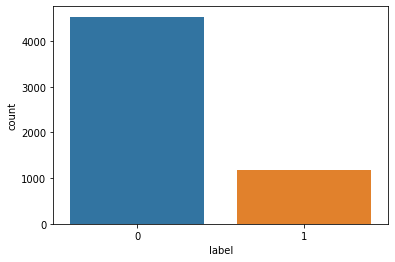

In [25]:
sns.countplot(label_2011_11);
label_2011_11.value_counts()

## LightGBM Hyperparameter 선언
- early stopping 기능을 사용하기 위해 n_estimators, early_stopping_rounds 설정

In [26]:
model_params = {
    'objective': 'binary', # 이진 분류
    'boosting_type': 'gbdt',
    'metric': 'auc', # 평가 지표 설정
    'feature_fraction': 0.8, # 피처 샘플링 비율
    'bagging_fraction': 0.8, # 데이터 샘플링 비율
    'bagging_freq': 1,
    'n_estimators': 10000, # 트리 개수
    'early_stopping_rounds': 100,
    'seed': SEED,
    'verbose': -1,
    'n_jobs': -1,    
}

## 2011년 11월 베이스라인 모델 예측
- Validation 성능 측정

In [27]:
data['order_month'] = data['order_day'].str.slice(start=0,stop=7)
data

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,order_day,order_month
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,11.4675,13085,United Kingdom,137.6100,2009-12-01 07:45:00,2009-12
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.6500,2009-12-01 07:45:00,2009-12
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.6500,2009-12-01 07:45:00,2009-12
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,3.4650,13085,United Kingdom,166.3200,2009-12-01 07:45:00,2009-12
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,2.0625,13085,United Kingdom,49.5000,2009-12-01 07:45:00,2009-12
...,...,...,...,...,...,...,...,...,...,...,...
780497,C579886,22197,POPCORN HOLDER,-1,2011-11-30 17:39:00,1.4025,15676,United Kingdom,-1.4025,2011-11-30 17:39:00,2011-11
780498,C579886,23146,TRIPLE HOOK ANTIQUE IVORY ROSE,-1,2011-11-30 17:39:00,5.4285,15676,United Kingdom,-5.4285,2011-11-30 17:39:00,2011-11
780499,C579887,84946,ANTIQUE SILVER T-LIGHT GLASS,-1,2011-11-30 17:42:00,2.0625,16717,United Kingdom,-2.0625,2011-11-30 17:42:00,2011-11
780500,C579887,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,-1,2011-11-30 17:42:00,13.1175,16717,United Kingdom,-13.1175,2011-11-30 17:42:00,2011-11


In [28]:
train, test, y, features = feature_engineering2(data, '2011-11')

categorical feature: []
x_tr.shape (5501, 129) , x_te.shape (5722, 129)


In [29]:
train.head()

,customer_id,year_month,label,total_3,total_6,total_9,total_12,total_15,total_18,total_21,cnt_month,mean_total,diff_fin,quantity-mean,quantity-max,quantity-min,quantity-sum,quantity-count,quantity-std,quantity-skew,price-mean,price-max,price-min,price-sum,price-count,price-std,price-skew,total-mean,total-max,total-min,total-sum,total-count,total-std,total-skew,cumsum_total_by_cust_id-mean,cumsum_total_by_cust_id-max,cumsum_total_by_cust_id-min,cumsum_total_by_cust_id-sum,cumsum_total_by_cust_id-count,cumsum_total_by_cust_id-std,cumsum_total_by_cust_id-skew,cumsum_quantity_by_cust_id-mean,cumsum_quantity_by_cust_id-max,cumsum_quantity_by_cust_id-min,cumsum_quantity_by_cust_id-sum,cumsum_quantity_by_cust_id-count,cumsum_quantity_by_cust_id-std,cumsum_quantity_by_cust_id-skew,cumsum_price_by_cust_id-mean,cumsum_price_by_cust_id-max,cumsum_price_by_cust_id-min,cumsum_price_by_cust_id-sum,cumsum_price_by_cust_id-count,cumsum_price_by_cust_id-std,cumsum_price_by_cust_id-skew,cumsum_total_by_prod_id-mean,cumsum_total_by_prod_id-max,cumsum_total_by_prod_id-min,cumsum_total_by_prod_id-sum,cumsum_total_by_prod_id-count,cumsum_total_by_prod_id-std,cumsum_total_by_prod_id-skew,cumsum_quantity_by_prod_id-mean,cumsum_quantity_by_prod_id-max,cumsum_quantity_by_prod_id-min,cumsum_quantity_by_prod_id-sum,cumsum_quantity_by_prod_id-count,cumsum_quantity_by_prod_id-std,cumsum_quantity_by_prod_id-skew,cumsum_price_by_prod_id-mean,cumsum_price_by_prod_id-max,cumsum_price_by_prod_id-min,cumsum_price_by_prod_id-sum,cumsum_price_by_prod_id-count,cumsum_price_by_prod_id-std,cumsum_price_by_prod_id-skew,cumsum_total_by_order_id-mean,cumsum_total_by_order_id-max,cumsum_total_by_order_id-min,cumsum_total_by_order_id-sum,cumsum_total_by_order_id-count,cumsum_total_by_order_id-std,cumsum_total_by_order_id-skew,cumsum_quantity_by_order_id-mean,cumsum_quantity_by_order_id-max,cumsum_quantity_by_order_id-min,cumsum_quantity_by_order_id-sum,cumsum_quantity_by_order_id-count,cumsum_quantity_by_order_id-std,cumsum_quantity_by_order_id-skew,cumsum_price_by_order_id-mean,cumsum_price_by_order_id-max,cumsum_price_by_order_id-min,cumsum_price_by_order_id-sum,cumsum_price_by_order_id-count,cumsum_price_by_order_id-std,cumsum_price_by_order_id-skew,order_id-nunique,product_id-nunique,order_ts-first,order_ts-last,order_ts_diff-mean,order_ts_diff-max,order_ts_diff-min,order_ts_diff-sum,order_ts_diff-count,order_ts_diff-std,order_ts_diff-skew,quantity_diff-mean,quantity_diff-max,quantity_diff-min,quantity_diff-sum,quantity_diff-count,quantity_diff-std,quantity_diff-skew,price_diff-mean,price_diff-max,price_diff-min,price_diff-sum,price_diff-count,price_diff-std,price_diff-skew,total_diff-mean,total_diff-max,total_diff-min,total_diff-sum,total_diff-count,total_diff-std,total_diff-skew
0,12346,2011-10,0,707.06625,849.64275,0.0000,-9.0750,-9.0750,-295.0035,-272.6460,6.0,-14.228500,6.0,1.127660,74215.0,-74215.0,53.0,47.0,15474.897433,-0.000228,19.922872,234.8115,1.6500,936.3750,47.0,40.530554,4.547689,-1.816404,127352.94,-127352.9400,-85.3710,47.0,26554.972603,0.000214,2953.304457,127267.5690,-85.3710,138805.3095,47.0,18527.811314,6.855058,1631.063830,74268.0,10.0,76660.0,47.0,10825.525671,6.855636,400.641415,936.3750,7.4250,18830.1465,47.0,262.090504,0.440160,-18933.867255,127352.9400,-145015.2000,-8.898918e+05,47.0,64968.445670,-1.131166,2354.212766,74215.0,-1644.0,110648.0,47.0,10767.598390,6.742285,63650.017691,325951.2630,1.6500,2.991551e+06,47.0,128903.599171,1.619409,24.297128,127352.9400,-127352.9400,1141.9650,47.0,26555.274233,-0.002867,3.914894,74215.0,-74215.0,184.0,47.0,15474.899161,-0.000793,80.737660,412.5990,1.6500,3794.6700,47.0,87.485676,1.486909,17.0,30.0,1.260780e+09,1.295346e+09,751438.695652,10197900.0,0.0,34566180.0,46.0,2.323281e+06,3.439852,-1613.586957,74216.0,-148430.0,-74225.0,46.0,24684.548109,-4.214331,-1.241087e-01,182.3745,-233.1615,-5.709000e+00,46.0,56.879462,-0.840908,-2770.156304,127360.365,-254705.880,-127427.1900,46.0,42359.030338,-4.2140

In [30]:
test.head()

,customer_id,year_month,label,total_3,total_6,total_9,total_12,total_15,total_18,total_21,cnt_month,mean_total,diff_fin,quantity-mean,quantity-max,quantity-min,quantity-sum,quantity-count,quantity-std,quantity-skew,price-mean,price-max,price-min,price-sum,price-count,price-std,price-skew,total-mean,total-max,total-min,total-sum,total-count,total-std,total-skew,cumsum_total_by_cust_id-mean,cumsum_total_by_cust_id-max,cumsum_total_by_cust_id-min,cumsum_total_by_cust_id-sum,cumsum_total_by_cust_id-count,cumsum_total_by_cust_id-std,cumsum_total_by_cust_id-skew,cumsum_quantity_by_cust_id-mean,cumsum_quantity_by_cust_id-max,cumsum_quantity_by_cust_id-min,cumsum_quantity_by_cust_id-sum,cumsum_quantity_by_cust_id-count,cumsum_quantity_by_cust_id-std,cumsum_quantity_by_cust_id-skew,cumsum_price_by_cust_id-mean,cumsum_price_by_cust_id-max,cumsum_price_by_cust_id-min,cumsum_price_by_cust_id-sum,cumsum_price_by_cust_id-count,cumsum_price_by_cust_id-std,cumsum_price_by_cust_id-skew,cumsum_total_by_prod_id-mean,cumsum_total_by_prod_id-max,cumsum_total_by_prod_id-min,cumsum_total_by_prod_id-sum,cumsum_total_by_prod_id-count,cumsum_total_by_prod_id-std,cumsum_total_by_prod_id-skew,cumsum_quantity_by_prod_id-mean,cumsum_quantity_by_prod_id-max,cumsum_quantity_by_prod_id-min,cumsum_quantity_by_prod_id-sum,cumsum_quantity_by_prod_id-count,cumsum_quantity_by_prod_id-std,cumsum_quantity_by_prod_id-skew,cumsum_price_by_prod_id-mean,cumsum_price_by_prod_id-max,cumsum_price_by_prod_id-min,cumsum_price_by_prod_id-sum,cumsum_price_by_prod_id-count,cumsum_price_by_prod_id-std,cumsum_price_by_prod_id-skew,cumsum_total_by_order_id-mean,cumsum_total_by_order_id-max,cumsum_total_by_order_id-min,cumsum_total_by_order_id-sum,cumsum_total_by_order_id-count,cumsum_total_by_order_id-std,cumsum_total_by_order_id-skew,cumsum_quantity_by_order_id-mean,cumsum_quantity_by_order_id-max,cumsum_quantity_by_order_id-min,cumsum_quantity_by_order_id-sum,cumsum_quantity_by_order_id-count,cumsum_quantity_by_order_id-std,cumsum_quantity_by_order_id-skew,cumsum_price_by_order_id-mean,cumsum_price_by_order_id-max,cumsum_price_by_order_id-min,cumsum_price_by_order_id-sum,cumsum_price_by_order_id-count,cumsum_price_by_order_id-std,cumsum_price_by_order_id-skew,order_id-nunique,product_id-nunique,order_ts-first,order_ts-last,order_ts_diff-mean,order_ts_diff-max,order_ts_diff-min,order_ts_diff-sum,order_ts_diff-count,order_ts_diff-std,order_ts_diff-skew,quantity_diff-mean,quantity_diff-max,quantity_diff-min,quantity_diff-sum,quantity_diff-count,quantity_diff-std,quantity_diff-skew,price_diff-mean,price_diff-max,price_diff-min,price_diff-sum,price_diff-count,price_diff-std,price_diff-skew,total_diff-mean,total_diff-max,total_diff-min,total_diff-sum,total_diff-count,total_diff-std,total_diff-skew
0,12346,2011-11,0,707.06625,849.64275,934.56,0.00000,-9.0750,-295.0035,-250.3710,6.0,-14.228500,7.0,1.127660,74215.0,-74215.0,53.0,47.0,15474.897433,-0.000228,19.922872,234.8115,1.6500,936.3750,47.0,40.530554,4.547689,-1.816404,127352.94,-127352.9400,-85.3710,47.0,26554.972603,0.000214,2953.304457,127267.5690,-85.3710,138805.3095,47.0,18527.811314,6.855058,1631.063830,74268.0,10.0,76660.0,47.0,10825.525671,6.855636,400.641415,936.3750,7.4250,18830.1465,47.0,262.090504,0.440160,-18933.867255,127352.9400,-145015.2000,-8.898918e+05,47.0,64968.445670,-1.131166,2354.212766,74215.0,-1644.0,110648.0,47.0,10767.598390,6.742285,63650.017691,325951.2630,1.6500,2.991551e+06,47.0,128903.599171,1.619409,24.297128,127352.940,-127352.9400,1141.9650,47.0,26555.274233,-0.002867,3.914894,74215.0,-74215.0,184.0,47.0,15474.899161,-0.000793,80.737660,412.599,1.6500,3794.6700,47.0,87.485676,1.486909,17.0,30.0,1.260780e+09,1.295346e+09,751438.695652,10197900.0,0.0,34566180.0,46.0,2.323281e+06,3.439852,-1613.586957,74216.0,-148430.0,-74225.0,46.0,24684.548109,-4.214331,-1.241087e-01,182.3745,-233.1615,-5.709000e+00,46.0,56.879462,-0.840908,-2770.156304,127360.365,-254705.880,-127427.1900,46.0,42359.030338,-4.214047

In [31]:
features

Index(['total_3', 'total_6', 'total_9', 'total_12', 'total_15', 'total_18',
       'total_21', 'cnt_month', 'mean_total', 'diff_fin',
       ...
       'price_diff-count', 'price_diff-std', 'price_diff-skew',
       'total_diff-mean', 'total_diff-max', 'total_diff-min', 'total_diff-sum',
       'total_diff-count', 'total_diff-std', 'total_diff-skew'],
      dtype='object', length=126)

In [32]:
# train = train.drop(['order_ts_diff-min'#'last_month',
# # 'total-count',
# #                     'cumsum_total_by_cust_id-count','cumsum_quantity_by_cust_id-count',
# # 'cumsum_price_by_cust_id-count','cumsum_total_by_prod_id-count','cumsum_quantity_by_prod_id-count',
# # 'cumsum_price_by_prod_id-count','cumsum_total_by_order_id-count','cumsum_quantity_by_order_id-count',
# # 'cumsum_price_by_order_id-count',
# # #                     'order_ts_diff-min','order_ts_diff-count','quantity_diff-count',
# # 'price_diff-count','total_diff-count'
# ],axis=1)
# test = test.drop(['order_ts_diff-min'#'last_month',
# # 'total-count',
# #                   'cumsum_total_by_cust_id-count','cumsum_quantity_by_cust_id-count',
# # 'cumsum_price_by_cust_id-count','cumsum_total_by_prod_id-count','cumsum_quantity_by_prod_id-count',
# # 'cumsum_price_by_prod_id-count','cumsum_total_by_order_id-count','cumsum_quantity_by_order_id-count',
# # 'cumsum_price_by_order_id-count',
# #                   'order_ts_diff-min','order_ts_diff-count','quantity_diff-count',
# # 'price_diff-count','total_diff-count'
#                  ],axis=1)

In [33]:
train.head()

,customer_id,year_month,label,total_3,total_6,total_9,total_12,total_15,total_18,total_21,cnt_month,mean_total,diff_fin,quantity-mean,quantity-max,quantity-min,quantity-sum,quantity-count,quantity-std,quantity-skew,price-mean,price-max,price-min,price-sum,price-count,price-std,price-skew,total-mean,total-max,total-min,total-sum,total-count,total-std,total-skew,cumsum_total_by_cust_id-mean,cumsum_total_by_cust_id-max,cumsum_total_by_cust_id-min,cumsum_total_by_cust_id-sum,cumsum_total_by_cust_id-count,cumsum_total_by_cust_id-std,cumsum_total_by_cust_id-skew,cumsum_quantity_by_cust_id-mean,cumsum_quantity_by_cust_id-max,cumsum_quantity_by_cust_id-min,cumsum_quantity_by_cust_id-sum,cumsum_quantity_by_cust_id-count,cumsum_quantity_by_cust_id-std,cumsum_quantity_by_cust_id-skew,cumsum_price_by_cust_id-mean,cumsum_price_by_cust_id-max,cumsum_price_by_cust_id-min,cumsum_price_by_cust_id-sum,cumsum_price_by_cust_id-count,cumsum_price_by_cust_id-std,cumsum_price_by_cust_id-skew,cumsum_total_by_prod_id-mean,cumsum_total_by_prod_id-max,cumsum_total_by_prod_id-min,cumsum_total_by_prod_id-sum,cumsum_total_by_prod_id-count,cumsum_total_by_prod_id-std,cumsum_total_by_prod_id-skew,cumsum_quantity_by_prod_id-mean,cumsum_quantity_by_prod_id-max,cumsum_quantity_by_prod_id-min,cumsum_quantity_by_prod_id-sum,cumsum_quantity_by_prod_id-count,cumsum_quantity_by_prod_id-std,cumsum_quantity_by_prod_id-skew,cumsum_price_by_prod_id-mean,cumsum_price_by_prod_id-max,cumsum_price_by_prod_id-min,cumsum_price_by_prod_id-sum,cumsum_price_by_prod_id-count,cumsum_price_by_prod_id-std,cumsum_price_by_prod_id-skew,cumsum_total_by_order_id-mean,cumsum_total_by_order_id-max,cumsum_total_by_order_id-min,cumsum_total_by_order_id-sum,cumsum_total_by_order_id-count,cumsum_total_by_order_id-std,cumsum_total_by_order_id-skew,cumsum_quantity_by_order_id-mean,cumsum_quantity_by_order_id-max,cumsum_quantity_by_order_id-min,cumsum_quantity_by_order_id-sum,cumsum_quantity_by_order_id-count,cumsum_quantity_by_order_id-std,cumsum_quantity_by_order_id-skew,cumsum_price_by_order_id-mean,cumsum_price_by_order_id-max,cumsum_price_by_order_id-min,cumsum_price_by_order_id-sum,cumsum_price_by_order_id-count,cumsum_price_by_order_id-std,cumsum_price_by_order_id-skew,order_id-nunique,product_id-nunique,order_ts-first,order_ts-last,order_ts_diff-mean,order_ts_diff-max,order_ts_diff-min,order_ts_diff-sum,order_ts_diff-count,order_ts_diff-std,order_ts_diff-skew,quantity_diff-mean,quantity_diff-max,quantity_diff-min,quantity_diff-sum,quantity_diff-count,quantity_diff-std,quantity_diff-skew,price_diff-mean,price_diff-max,price_diff-min,price_diff-sum,price_diff-count,price_diff-std,price_diff-skew,total_diff-mean,total_diff-max,total_diff-min,total_diff-sum,total_diff-count,total_diff-std,total_diff-skew
0,12346,2011-10,0,707.06625,849.64275,0.0000,-9.0750,-9.0750,-295.0035,-272.6460,6.0,-14.228500,6.0,1.127660,74215.0,-74215.0,53.0,47.0,15474.897433,-0.000228,19.922872,234.8115,1.6500,936.3750,47.0,40.530554,4.547689,-1.816404,127352.94,-127352.9400,-85.3710,47.0,26554.972603,0.000214,2953.304457,127267.5690,-85.3710,138805.3095,47.0,18527.811314,6.855058,1631.063830,74268.0,10.0,76660.0,47.0,10825.525671,6.855636,400.641415,936.3750,7.4250,18830.1465,47.0,262.090504,0.440160,-18933.867255,127352.9400,-145015.2000,-8.898918e+05,47.0,64968.445670,-1.131166,2354.212766,74215.0,-1644.0,110648.0,47.0,10767.598390,6.742285,63650.017691,325951.2630,1.6500,2.991551e+06,47.0,128903.599171,1.619409,24.297128,127352.9400,-127352.9400,1141.9650,47.0,26555.274233,-0.002867,3.914894,74215.0,-74215.0,184.0,47.0,15474.899161,-0.000793,80.737660,412.5990,1.6500,3794.6700,47.0,87.485676,1.486909,17.0,30.0,1.260780e+09,1.295346e+09,751438.695652,10197900.0,0.0,34566180.0,46.0,2.323281e+06,3.439852,-1613.586957,74216.0,-148430.0,-74225.0,46.0,24684.548109,-4.214331,-1.241087e-01,182.3745,-233.1615,-5.709000e+00,46.0,56.879462,-0.840908,-2770.156304,127360.365,-254705.880,-127427.1900,46.0,42359.030338,-4.2140

In [34]:
y_oof, test_preds_2011_11, fi = make_lgb_oof_prediction(train, y, test, features, model_params=model_params)
print_score(label_2011_11, test_preds_2011_11)

fold: 1, x_tr.shape: (4950, 126), x_val.shape: (551, 126)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[20]	training's auc: 0.941408	valid_1's auc: 0.773823
Fold 1 | AUC: 0.7738227146814405
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (4951, 126), x_val.shape: (550, 126)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[18]	training's auc: 0.929939	valid_1's auc: 0.849734
Fold 2 | AUC: 0.8497340425531915
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (4951, 126), x_val.shape: (550, 126)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[13]	training's auc: 0.905243	valid_1's auc: 0.79078
Fold 3 | AUC: 0.7907801418439716
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (4951, 126)

## 2011년 11월 베이스라인 모델 예측 데이터 분포

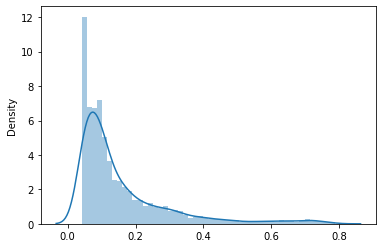

In [35]:
sns.distplot(test_preds_2011_11)
plt.show()

## 2011년 12월 베이스라인 모델 예측
- 테스트 데이터 제출

In [36]:
train, test, y, features = feature_engineering2(data, '2011-12')
y_oof, test_preds, fi = make_lgb_oof_prediction(train, y, test, features, model_params=model_params)

categorical feature: []
x_tr.shape (5722, 129) , x_te.shape (5914, 129)
fold: 1, x_tr.shape: (5149, 126), x_val.shape: (573, 126)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[11]	training's auc: 0.905489	valid_1's auc: 0.814108
Fold 1 | AUC: 0.814108022063451
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 126), x_val.shape: (573, 126)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[15]	training's auc: 0.915597	valid_1's auc: 0.818652
Fold 2 | AUC: 0.8186521304557064
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 126), x_val.shape: (572, 126)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[36]	training's auc: 0.970681	valid_1's auc: 0.85162
Fold 3 | AUC: 0.8516202493840065
------------------------------------------

## 2011년 12월 베이스라인 모델 예측 데이터 분포

In [37]:
train.head()

,customer_id,year_month,label,total_3,total_6,total_9,total_12,total_15,total_18,total_21,cnt_month,mean_total,diff_fin,quantity-mean,quantity-max,quantity-min,quantity-sum,quantity-count,quantity-std,quantity-skew,price-mean,price-max,price-min,price-sum,price-count,price-std,price-skew,total-mean,total-max,total-min,total-sum,total-count,total-std,total-skew,cumsum_total_by_cust_id-mean,cumsum_total_by_cust_id-max,cumsum_total_by_cust_id-min,cumsum_total_by_cust_id-sum,cumsum_total_by_cust_id-count,cumsum_total_by_cust_id-std,cumsum_total_by_cust_id-skew,cumsum_quantity_by_cust_id-mean,cumsum_quantity_by_cust_id-max,cumsum_quantity_by_cust_id-min,cumsum_quantity_by_cust_id-sum,cumsum_quantity_by_cust_id-count,cumsum_quantity_by_cust_id-std,cumsum_quantity_by_cust_id-skew,cumsum_price_by_cust_id-mean,cumsum_price_by_cust_id-max,cumsum_price_by_cust_id-min,cumsum_price_by_cust_id-sum,cumsum_price_by_cust_id-count,cumsum_price_by_cust_id-std,cumsum_price_by_cust_id-skew,cumsum_total_by_prod_id-mean,cumsum_total_by_prod_id-max,cumsum_total_by_prod_id-min,cumsum_total_by_prod_id-sum,cumsum_total_by_prod_id-count,cumsum_total_by_prod_id-std,cumsum_total_by_prod_id-skew,cumsum_quantity_by_prod_id-mean,cumsum_quantity_by_prod_id-max,cumsum_quantity_by_prod_id-min,cumsum_quantity_by_prod_id-sum,cumsum_quantity_by_prod_id-count,cumsum_quantity_by_prod_id-std,cumsum_quantity_by_prod_id-skew,cumsum_price_by_prod_id-mean,cumsum_price_by_prod_id-max,cumsum_price_by_prod_id-min,cumsum_price_by_prod_id-sum,cumsum_price_by_prod_id-count,cumsum_price_by_prod_id-std,cumsum_price_by_prod_id-skew,cumsum_total_by_order_id-mean,cumsum_total_by_order_id-max,cumsum_total_by_order_id-min,cumsum_total_by_order_id-sum,cumsum_total_by_order_id-count,cumsum_total_by_order_id-std,cumsum_total_by_order_id-skew,cumsum_quantity_by_order_id-mean,cumsum_quantity_by_order_id-max,cumsum_quantity_by_order_id-min,cumsum_quantity_by_order_id-sum,cumsum_quantity_by_order_id-count,cumsum_quantity_by_order_id-std,cumsum_quantity_by_order_id-skew,cumsum_price_by_order_id-mean,cumsum_price_by_order_id-max,cumsum_price_by_order_id-min,cumsum_price_by_order_id-sum,cumsum_price_by_order_id-count,cumsum_price_by_order_id-std,cumsum_price_by_order_id-skew,order_id-nunique,product_id-nunique,order_ts-first,order_ts-last,order_ts_diff-mean,order_ts_diff-max,order_ts_diff-min,order_ts_diff-sum,order_ts_diff-count,order_ts_diff-std,order_ts_diff-skew,quantity_diff-mean,quantity_diff-max,quantity_diff-min,quantity_diff-sum,quantity_diff-count,quantity_diff-std,quantity_diff-skew,price_diff-mean,price_diff-max,price_diff-min,price_diff-sum,price_diff-count,price_diff-std,price_diff-skew,total_diff-mean,total_diff-max,total_diff-min,total_diff-sum,total_diff-count,total_diff-std,total_diff-skew
0,12346,2011-11,0,739.8105,882.3870,960.86925,0.0000,-9.0750,-295.0035,-250.3710,6.0,-14.228500,7.0,1.127660,74215.0,-74215.0,53.0,47.0,15474.897433,-0.000228,19.922872,234.8115,1.6500,936.3750,47.0,40.530554,4.547689,-1.816404,127352.94,-127352.9400,-85.3710,47.0,26554.972603,0.000214,2953.304457,127267.5690,-85.3710,138805.3095,47.0,18527.811314,6.855058,1631.063830,74268.0,10.0,76660.0,47.0,10825.525671,6.855636,400.641415,936.3750,7.4250,18830.1465,47.0,262.090504,0.440160,-18933.867255,127352.9400,-145015.2000,-8.898918e+05,47.0,64968.445670,-1.131166,2354.212766,74215.0,-1644.0,110648.0,47.0,10767.598390,6.742285,63650.017691,325951.2630,1.6500,2.991551e+06,47.0,128903.599171,1.619409,24.297128,127352.940,-127352.9400,1141.9650,47.0,26555.274233,-0.002867,3.914894,74215.0,-74215.0,184.0,47.0,15474.899161,-0.000793,80.737660,412.599,1.6500,3794.6700,47.0,87.485676,1.486909,17.0,30.0,1.260780e+09,1.295346e+09,751438.695652,10197900.0,0.0,34566180.0,46.0,2.323281e+06,3.439852,-1613.586957,74216.0,-148430.0,-74225.0,46.0,24684.548109,-4.214331,-1.241087e-01,182.3745,-233.1615,-5.709000e+00,46.0,56.879462,-0.840908,-2770.156304,127360.365,-254705.880,-127427.1900,46.0,42359.030338,-4.214047

In [38]:
test.head()

,customer_id,year_month,label,total_3,total_6,total_9,total_12,total_15,total_18,total_21,cnt_month,mean_total,diff_fin,quantity-mean,quantity-max,quantity-min,quantity-sum,quantity-count,quantity-std,quantity-skew,price-mean,price-max,price-min,price-sum,price-count,price-std,price-skew,total-mean,total-max,total-min,total-sum,total-count,total-std,total-skew,cumsum_total_by_cust_id-mean,cumsum_total_by_cust_id-max,cumsum_total_by_cust_id-min,cumsum_total_by_cust_id-sum,cumsum_total_by_cust_id-count,cumsum_total_by_cust_id-std,cumsum_total_by_cust_id-skew,cumsum_quantity_by_cust_id-mean,cumsum_quantity_by_cust_id-max,cumsum_quantity_by_cust_id-min,cumsum_quantity_by_cust_id-sum,cumsum_quantity_by_cust_id-count,cumsum_quantity_by_cust_id-std,cumsum_quantity_by_cust_id-skew,cumsum_price_by_cust_id-mean,cumsum_price_by_cust_id-max,cumsum_price_by_cust_id-min,cumsum_price_by_cust_id-sum,cumsum_price_by_cust_id-count,cumsum_price_by_cust_id-std,cumsum_price_by_cust_id-skew,cumsum_total_by_prod_id-mean,cumsum_total_by_prod_id-max,cumsum_total_by_prod_id-min,cumsum_total_by_prod_id-sum,cumsum_total_by_prod_id-count,cumsum_total_by_prod_id-std,cumsum_total_by_prod_id-skew,cumsum_quantity_by_prod_id-mean,cumsum_quantity_by_prod_id-max,cumsum_quantity_by_prod_id-min,cumsum_quantity_by_prod_id-sum,cumsum_quantity_by_prod_id-count,cumsum_quantity_by_prod_id-std,cumsum_quantity_by_prod_id-skew,cumsum_price_by_prod_id-mean,cumsum_price_by_prod_id-max,cumsum_price_by_prod_id-min,cumsum_price_by_prod_id-sum,cumsum_price_by_prod_id-count,cumsum_price_by_prod_id-std,cumsum_price_by_prod_id-skew,cumsum_total_by_order_id-mean,cumsum_total_by_order_id-max,cumsum_total_by_order_id-min,cumsum_total_by_order_id-sum,cumsum_total_by_order_id-count,cumsum_total_by_order_id-std,cumsum_total_by_order_id-skew,cumsum_quantity_by_order_id-mean,cumsum_quantity_by_order_id-max,cumsum_quantity_by_order_id-min,cumsum_quantity_by_order_id-sum,cumsum_quantity_by_order_id-count,cumsum_quantity_by_order_id-std,cumsum_quantity_by_order_id-skew,cumsum_price_by_order_id-mean,cumsum_price_by_order_id-max,cumsum_price_by_order_id-min,cumsum_price_by_order_id-sum,cumsum_price_by_order_id-count,cumsum_price_by_order_id-std,cumsum_price_by_order_id-skew,order_id-nunique,product_id-nunique,order_ts-first,order_ts-last,order_ts_diff-mean,order_ts_diff-max,order_ts_diff-min,order_ts_diff-sum,order_ts_diff-count,order_ts_diff-std,order_ts_diff-skew,quantity_diff-mean,quantity_diff-max,quantity_diff-min,quantity_diff-sum,quantity_diff-count,quantity_diff-std,quantity_diff-skew,price_diff-mean,price_diff-max,price_diff-min,price_diff-sum,price_diff-count,price_diff-std,price_diff-skew,total_diff-mean,total_diff-max,total_diff-min,total_diff-sum,total_diff-count,total_diff-std,total_diff-skew
0,12346,2011-12,0,739.8105,882.3870,960.86925,0.0000,-9.0750,-295.0035,-250.3710,6.0,-14.228500,8.0,1.127660,74215.0,-74215.0,53.0,47.0,15474.897433,-0.000228,19.922872,234.8115,1.6500,936.3750,47.0,40.530554,4.547689,-1.816404,127352.94,-127352.9400,-85.3710,47.0,26554.972603,0.000214,2953.304457,127267.5690,-85.3710,138805.3095,47.0,18527.811314,6.855058,1631.063830,74268.0,10.0,76660.0,47.0,10825.525671,6.855636,400.641415,936.3750,7.4250,18830.1465,47.0,262.090504,0.440160,-18933.867255,127352.9400,-145015.2000,-8.898918e+05,47.0,64968.445670,-1.131166,2354.212766,74215.0,-1644.0,110648.0,47.0,10767.598390,6.742285,63650.017691,325951.2630,1.6500,2.991551e+06,47.0,128903.599171,1.619409,24.297128,127352.9400,-127352.9400,1141.9650,47.0,26555.274233,-0.002867,3.914894,74215.0,-74215.0,184.0,47.0,15474.899161,-0.000793,80.737660,412.599,1.6500,3794.6700,47.0,87.485676,1.486909,17.0,30.0,1.260780e+09,1.295346e+09,751438.695652,10197900.0,0.0,34566180.0,46.0,2.323281e+06,3.439852,-1613.586957,74216.0,-148430.0,-74225.0,46.0,24684.548109,-4.214331,-1.241087e-01,182.3745,-233.1615,-5.709000e+00,46.0,56.879462,-0.840908,-2770.156304,127360.365,-254705.880,-127427.1900,46.0,42359.030338,-4.21404

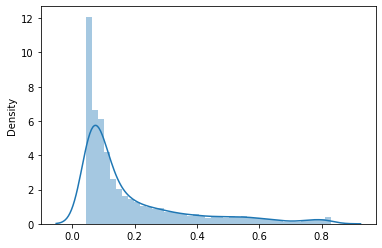

In [39]:
sns.distplot(test_preds)
plt.show()

## 피처 중요도 플롯

In [40]:
fi

,feature,fold_1,fold_2,fold_3,fold_4,fold_5,fold_6,fold_7,fold_8,fold_9,fold_10,importance
0,total_3,5,6,24,8,11,48,6,21,120,3,25.2
1,total_6,4,12,16,13,16,41,6,32,121,3,26.4
2,total_9,5,4,13,9,9,35,7,20,100,3,20.5
3,total_12,21,21,33,25,28,64,19,44,147,17,41.9
4,total_15,9,12,15,12,7,37,4,23,90,4,21.3
5,total_18,1,2,3,4,5,16,3,7,53,2,9.6
6,total_21,1,1,6,0,4,20,2,10,40,3,8.7
7,cnt_month,5,6,7,8,4,11,6,5,34,3,8.9
8,mean_total,1,3,7,5,1,42,3,19,103,1,18.5
9,diff_fin,0,2,9,3,2,21,6,11,49,0,10.3


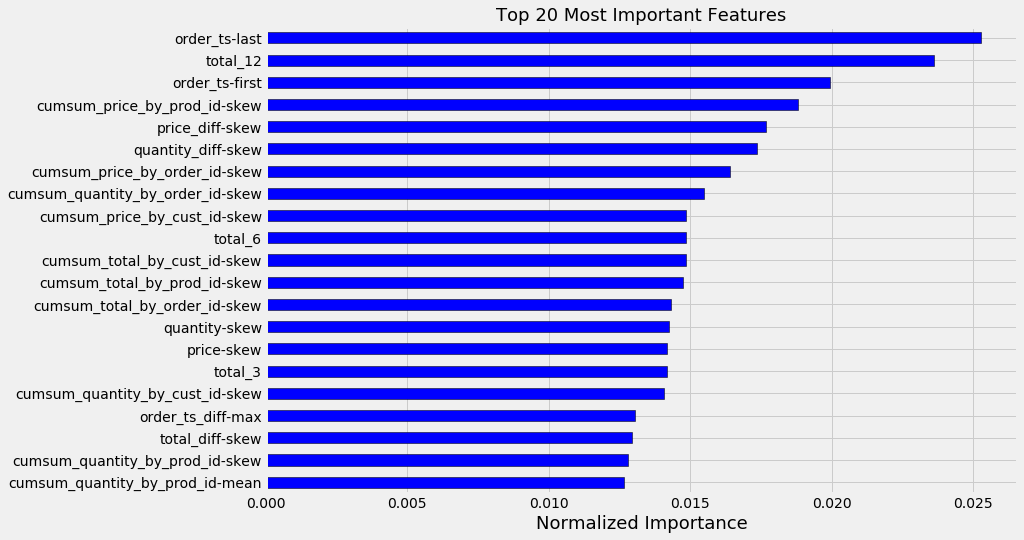

In [41]:
fi_plot = plot_feature_importances(fi)

# 제출 파일 생성

In [42]:
output_dir = 'code/output'
os.makedirs(output_dir, exist_ok=True)
submission = pd.read_csv('code/input/sample_submission.csv')
submission['probability'] = test_preds
submission.to_csv(os.path.join(output_dir, 'output4.csv'), index=False)

In [43]:
fi.to_csv(os.path.join(output_dir, 'features.csv'), index=False)

In [44]:
# print_score(pd.read_csv('../input/label.csv')['label'], test_preds)

In [45]:
# test_preds[:30]

In [46]:
ddd

NameError: name 'ddd' is not defined

In [ ]:
# 상관계수
dd = train.drop(['customer_id','label'],axis=1)
cor = dd.corr()
cor

In [ ]:
plt.figure(figsize=(30,18))
sns.heatmap(cor,annot=True)

# feature importance

In [ ]:
import eli5 
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, scoring = "f1", random_state = 42).fit(X_val, y_val)
eli5.show_weights(perm, top = 37, feature_names = X_val.columns.tolist())


In [ ]:
x_train = train.copy()
x_train = x_train.drop(['year_month','last_month','order_ts_diff-min'],axis=1)
x_train.head()

In [ ]:
x_train.isna().sum()

In [ ]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(x_train)

np.set_printoptions(suppress=True)  
pc_vs_variance = np.cumsum(pca.explained_variance_ratio_)

pc_vs_variance
plt.plot(pc_vs_variance)

In [ ]:
pca = PCA(n_components=5)
pca.fit(x_train)
x_train_2 = pca.transform(x_train)

# x_test_2 = pca.transform(test)

In [ ]:
x_train_2

## prd_imp label별 분포

In [ ]:
sample = train
sns.distplot(sample.loc[sample['label']==0, 'cumsum_quantity_by_prod_id-std'], label='label=0')
sns.distplot(sample.loc[sample['label']==1, 'cumsum_quantity_by_prod_id-std'], label='label=1')
plt.legend()
plt.show()

In [ ]:
sample = train
sns.distplot(sample.loc[sample['label']==0, 'mean_total'], label='label=0')
sns.distplot(sample.loc[sample['label']==1, 'mean_total'], label='label=1')
plt.legend()
plt.show()

In [ ]:
sample = train
sns.distplot(sample.loc[sample['label']==0, 'last_total'], label='label=0')
sns.distplot(sample.loc[sample['label']==1, 'last_total'], label='label=1')
plt.legend()
plt.show()

In [ ]:
sample = train
sns.distplot(sample.loc[sample['label']==0, 'total_15'], label='label=0')
sns.distplot(sample.loc[sample['label']==1, 'total_15'], label='label=1')
plt.legend()
plt.show()

In [ ]:
sample = train
sns.distplot(sample.loc[sample['label']==0, 'diff_fin'], label='label=0')
sns.distplot(sample.loc[sample['label']==1, 'diff_fin'], label='label=1')
plt.legend()
plt.show()